Copyright 2019 DeepMind Technologies Limited

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Intuitive Analysis of Gradient Estimators

This colab allows reproducing the plots in Figures 2 and 3 in Section 3 of the paper [1]. We consider a particular instance of the stochastic gradient problem, eqn. (10). We would like to stochastically estimate the following quantity:

$\eta = \nabla_{\theta} \int \mathcal{N}(x|\mu, \sigma^2) f(x; k) dx;  \quad \theta \in \{\mu, \sigma\}; \quad f \in \{(x-k)^2, \exp(-kx^2), \cos(kx)\}.$

Here the measure is a Gaussian distribution and the cost function is univariate.

In this experiment we consider several gradient estimators:
* Derivatives of measure
  * Score function gradient esimator (naive and variance-reduced version): Section 4
  * Measure-valued gradient estimator with variance reduction (coupling): Section 6
* Derivatives of path
  * Pathwise gradients: Section 5

Since all the estimators are unbiased (have the same expectation), we compare the _variance_ of these gradient estimators. A lower-variance estimator is almost universally preferred to a higher-variance one. For this simple univariate problem, we compute the variance via numerical integration to remove any noise in the measurements.

[1] [Shakir Mohamed, Mihaela Rosca, Michael Figurnov and Andriy Mnih, "Monte Carlo Gradient Estimation in Machine Learning". arXiv, 2019](https://arxiv.org/abs/1906.10652)

## Code

### Imports and global settings

In [0]:
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


sns.set_context('paper', font_scale=2.0, rc={'lines.linewidth': 2.0})
sns.set_style('whitegrid')

# We use INTEGRATION_LIMIT instead of infinity in integration limits
INTEGRATION_LIMIT = 10.
# Threshold for testing the unbiasedness of estimators
EPS = 1e-4
# Whether to save the resulting plots on disk
SAVE_PLOTS = True

### Costs

In [0]:
class SquareCost(object):
  """The cost f(x; k) = (x - k)^2"""
  name = 'square'

  def __init__(self, k):
    self.k = k

  def value(self, x):
    return (x - self.k) ** 2

  def derivative(self, x):
    return 2 * (x - self.k)


class CosineCost(object):
  """The cost f(x; k) = cos kx"""
  name = 'cos'

  def __init__(self, k):
    self.k = k

  def value(self, x):
    return np.cos(self.k * x)

  def derivative(self, x):
    return -self.k * np.sin(self.k * x)


class ExponentialCost(object):
  """The cost f(x; k) = exp(-k x^2)"""
  name = 'exp'

  def __init__(self, k):
    self.k = k

  def value(self, x):
    return np.exp(-self.k * x ** 2)

  def derivative(self, x):
    return (-2 * self.k * x) * np.exp(-self.k * x ** 2)

## Measures (probability distributions)

`verify_unbiasedness` flag adds an unbiasedness check for the gradient estimators. When computing the variance or covariance, it checks that the expectation of the estimator is equal to the desired value.

In [0]:
class Normal(object):
  """Univariate Normal (Gaussian) measure."""
  def __init__(self, mean, std, verify_unbiasedness):
    self.distrib = scipy.stats.norm(loc=mean, scale=std)
    self.mean = mean
    self.std = std
    self.verify_unbiasedness = verify_unbiasedness

  def expect(self, g):
    """Computes the mean: E_p(x) g(x)"""
    return scipy.integrate.quad(lambda x: self.distrib.pdf(x) * g(x),
                                -INTEGRATION_LIMIT, INTEGRATION_LIMIT)

  def var(self, g, expect_g):
    """Compute the variance given the mean: E_p(x) (g(x) - E g(x))^2"""
    if self.verify_unbiasedness:
      assert (self.expect(g)[0] - expect_g) ** 2 < EPS
    return self.expect(lambda x: (g(x) - expect_g) ** 2)

  def cov(self, g, expect_g, h, expect_h):
    """Computes the covariance of two functions given their means:
    
    E_p(x) (f(x) - E f(x)) (g(x) - E g(x))
    """
    if self.verify_unbiasedness:
      assert (self.expect(g)[0] - expect_g) ** 2 < EPS
      assert (self.expect(h)[0] - expect_h) ** 2 < EPS
    return self.expect(lambda x: (g(x) - expect_g) * (h(x) - expect_h))

  def dlogpdf_dmean(self, x):
    """Computes the score function for mean: \nabla_mean \log p(x; mean, std)
    
    The score function is part of the score function estimator, see eqn. (13)
    """
    return (x - self.mean) / self.std ** 2

  def dlogpdf_dstd(self, x):
    """Computes the score function for the std: \nabla_std \log p(x; mean, std)
    
    The score function is part of the score function estimator, see eqn. (13)
    """
    return -(((self.mean + self.std - x) *
              (-self.mean + self.std + x)) / self.std ** 3)

  def dx_dmean(self, x):
    """Computes \nabla_mean x.
    
    This is part of the pathwise estimator, see eqn. (35b).
    For derivation, see eqn. (37).
    """
    return 1.

  def dx_dstd(self, x):
    """Computes \nabla_std x.
    
    This is part of the pathwise estimator, see eqn. (35b).
    For derivation, see eqn. (37).
    """
    return (x - self.mean) / self.std


class StandardWeibull(object):
  """Weibull(2, 0.5) is a distribution used for measure-valued derivative w.r.t.
  Normal mean.
  
  See equation (46) for the derivation. This distribution has a density
  function x * exp(-x^2 / 2) for x > 0
  """
  def __init__(self, verify_unbiasedness):
    self.verify_unbiasedness = verify_unbiasedness

  def expect(self, g):
    """Computes the mean: E_Weibull(x) g(x)"""
    weibull_pdf = lambda x: x * np.exp(-0.5 * x ** 2)

    return scipy.integrate.quad(lambda x: weibull_pdf(x) * g(x),
                                0, INTEGRATION_LIMIT)

  def var(self, g, expect_g):
    """Compute the variance given the mean: E_Weibull(x) (g(x) - E g(x))^2"""
    if self.verify_unbiasedness:
      assert (self.expect(g)[0] - expect_g) ** 2 < EPS
    return self.expect(lambda x: (g(x) - expect_g) ** 2)


class StandardDsMaxwellCoupledWithNormal(object):
  """This is standard double-sided Maxwell distribution coupled with
  standard Normal distribution. This is a bivariate distribution which is used
  for measure-valued derivative w.r.t. Normal standard deviation, see Table 1.
  
  Standard double-sided Maxwell distribution has the density function
  x^2 exp(-x^2 / 2) / sqrt(2 pi) for x \in R.
  
  To reduce the variance of the estimator, we couple the positve
  (double-sided Maxwell) and negative (Gaussian) parts of the estimator.
  See Section 7.2 for discussion of this idea. Technically, this is achieved
  by representing a standard Normal sample as (m*u),
  where m ~ DSMaxwell and u ~ U[0, 1].
  """
  def __init__(self, verify_unbiasedness):
    self.verify_unbiasedness = verify_unbiasedness

  def expect(self, g):
    """Computes the mean E_p(m, n) g(m, n) where m has a marginal DS-Maxwell
    distribution and n has a marginal Normal distribution."""
    def ds_maxwell_pdf(x):
      return x ** 2 * np.exp(-0.5 * x ** 2) / np.sqrt(2 * np.pi)

    return scipy.integrate.dblquad(
        # m: Double Sided Maxwell, u: U[0, 1]
        # The PDF of U[0, 1] is constant 1.
        lambda m, u: ds_maxwell_pdf(m) * g(m, m * u),
        # Limits for Uniform
        0, 1,
        # Limits for Double Sided Maxwell. Infinity is not supported by dblquad.
        lambda x: -INTEGRATION_LIMIT, lambda x: INTEGRATION_LIMIT,
    )

  def var(self, g, expect_g):
    """Computes the variance E_p(m, n) (g(m, n) - E g(m, n)), where m has
    a marginal DS-Maxwell distribution and n has a marginal Normal
    distribution."""
    if self.verify_unbiasedness:
      assert (self.expect(g)[0] - expect_g) ** 2 < EPS
    return self.expect(lambda m, n: (g(m, n) - expect_g) ** 2)

### Numerical integration

In [0]:
def numerical_integration(Cost, k, mean, std, verify_unbiasedness=False):
  """This function numerically evaluates the variance of gradient estimators.

  Arguments:
    Cost: the class of a cost function
    k: a list/NumPy vector of values for the cost parameter k
    mean: a scalar parameter of the Normal measure
    std: a scalar parameter of the Normal measure
    verify_unbiasedness: if True, perform additional asserts that verify
      that the estimators are unbiased
  Returns:
    A dictionary {key: NumPy array}. The keys have the form var_..., where ...
      is the name of the estimator. The dimensions of the NumPy arrays are
      [len(k), 2, 2], where the second dimension is [dmean, dstd], and the last
      dimension is [value, integration_error].
  """

  measure = Normal(mean, std, verify_unbiasedness)
  weibull = StandardWeibull(verify_unbiasedness)
  ds_maxwell_coupled_with_normal = StandardDsMaxwellCoupledWithNormal(
      verify_unbiasedness)
  
  ret = {}
  for key in ['var_sf',
              'var_sf_mean_baseline',
              'var_sf_optimal_baseline',
              'var_pathwise',
              'var_measure_valued_coupled']:
    ret[key] = np.zeros([len(k), 2, 2])

  for i in range(len(k)):
    cost = Cost(k[i])

    expect_loss = measure.expect(cost.value)[0]
    # Compute $\nabla_{\theta} \int \mathcal{N}(x|\mu, \sigma^2) f(x; k) dx$
    # using the score-function estimator
    d_expect_loss = [
        measure.expect(lambda x: cost.value(x) * measure.dlogpdf_dmean(x))[0],
        measure.expect(lambda x: cost.value(x) * measure.dlogpdf_dstd(x))[0]
        ]

    # Variance of the score-function estimator: Section 4, eqn. (13)
    ret['var_sf'][i] = [
        measure.var(lambda x: cost.value(x) * measure.dlogpdf_dmean(x),
                    d_expect_loss[0]),
        measure.var(lambda x: cost.value(x) * measure.dlogpdf_dstd(x),
                    d_expect_loss[1])
        ]

    # Variance of the score-function estimator with the mean baseline
    # Section 4, eqn. (14)
    ret['var_sf_mean_baseline'][i] = [
        measure.var(lambda x: (cost.value(x) - expect_loss) * measure.dlogpdf_dmean(x),
                    d_expect_loss[0]),
        measure.var(lambda x: (cost.value(x) - expect_loss) * measure.dlogpdf_dstd(x),
                    d_expect_loss[1])
        ]

    # Computes the optimal baseline for the score-function estimator
    # using Section 7.4.1, eqn. (65).
    # Note that it has different values for mean and std.
    optimal_baseline = [
        (measure.cov(measure.dlogpdf_dmean, 0.,
                    lambda x: cost.value(x) * measure.dlogpdf_dmean(x),
                    d_expect_loss[0])[0]
        / measure.var(measure.dlogpdf_dmean, 0.)[0]),
        (measure.cov(measure.dlogpdf_dstd, 0.,
                    lambda x: cost.value(x) * measure.dlogpdf_dstd(x),
                    d_expect_loss[1])[0]
        / measure.var(measure.dlogpdf_dstd, 0.)[0])
        ]

    # Variance of the score-function estimator with the optimal baseline
    # Section 4, eqn. (14)
    ret['var_sf_optimal_baseline'][i] = [
        measure.var(lambda x: (cost.value(x) - optimal_baseline[0]) * measure.dlogpdf_dmean(x),
                    d_expect_loss[0]),
        measure.var(lambda x: (cost.value(x) - optimal_baseline[1]) * measure.dlogpdf_dstd(x),
                    d_expect_loss[1])
        ]

    # Variance of the pathwise estimator. Here we use the "implicit" form of the
    # estimator that allows reusing the same Gaussian measure.
    # See Section 5, eqn. (35) for details
    ret['var_pathwise'][i] = [
        measure.var(lambda x: cost.derivative(x) * measure.dx_dmean(x),
                    d_expect_loss[0]),
        measure.var(lambda x: cost.derivative(x) * measure.dx_dstd(x),
                    d_expect_loss[1])
        ]

    # Variance of the measure-valued gradient estimator (Section 6, eqn. (44),
    # Table 1) with variance reduction via coupling (Section 7.2)
    ret['var_measure_valued_coupled'][i] = [
        # We couple the Weibulls from the positive and negative parts of the
        # estimator simply by reusing the value of the Weibull
        weibull.var(
            lambda x: (cost.value(mean + std * x) - cost.value(mean - std * x)) / (np.sqrt(2 * np.pi) * std), d_expect_loss[0]),
        # See Section 7.2 and documentation of StandardDsMaxwellCoupledWithNormal
        # for details on this coupling. Here m ~ DS-Maxwell, n ~ Normal(0, 1)
        ds_maxwell_coupled_with_normal.var(
            lambda m, n: (cost.value(m * std + mean) - cost.value(n * std + mean)) / std, d_expect_loss[1])
        ]

  return ret

### Plotting

In [0]:
def plot(k, ret, param_idx, logx, logy, ylabel, ylim, filename, xticks=None):
  plt.figure(figsize=[8, 5])
  plt.plot(k, ret['var_sf'][:, param_idx, 0],
           label='Score function')
  # plt.plot(k, ret['var_sf_mean_baseline'][:, param_idx, 0],
  #          label='Score function + mean baseline')
  plt.plot(k, ret['var_sf_optimal_baseline'][:, param_idx, 0],
           label='Score function + variance reduction')
  plt.plot(k, ret['var_pathwise'][:, param_idx, 0],
           label='Pathwise')
  plt.plot(k, ret['var_measure_valued_coupled'][:, param_idx, 0],
           label='Measure-valued + variance reduction')
  plt.xlabel(r'$k$')
  plt.ylabel(ylabel)
  plt.xlim([np.min(k), np.max(k)])
  plt.ylim(ylim)
  if logx:
    plt.xscale('log')
  if logy:
    plt.yscale('log')
  if xticks is not None:
    plt.xticks(xticks)
    x_axis = plt.gca().get_xaxis()
    x_axis.set_ticklabels(xticks)
    x_axis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    x_axis.set_minor_formatter(matplotlib.ticker.NullFormatter())
  if SAVE_PLOTS:
    plt.savefig(filename, dpi=200, transparent=True)
  return plt.gca()

def plot_cost_cartoon(Cost, k, x, xticks, yticks, ylim, filename):
  f, axes = plt.subplots(1, 3, sharey='row', figsize=[12, 2])
  for i in range(len(k)):
    axes[i].plot(x, Cost(k[i]).value(x),
                 color='k', label='Value of the cost')
    axes[i].plot(x, Cost(k[i]).derivative(x),
                 color='k', linestyle='--', label='Derivative of the cost')
    axes[i].axis('on')
    axes[i].grid(False)
    axes[i].xaxis.set_tick_params(length=0)
    axes[i].xaxis.set_ticks(xticks)
    axes[i].yaxis.set_tick_params(length=0)
    axes[i].yaxis.set_ticks(yticks)
    axes[i].set_frame_on(False)
  axes[0].set_ylim(ylim)
  f.tight_layout()
  if SAVE_PLOTS:
    f.savefig(filename, dpi=200, transparent=True)
  return axes

### Test that the estimators are unbiased

In [0]:
for Cost in [SquareCost, CosineCost, ExponentialCost]:
  print(Cost.name)
  ret = numerical_integration(
      Cost, k=[0.1, 1., 10.], mean=1, std=1.5, verify_unbiasedness=True)
  print('Maximum integration error: {}'.format(
      max(np.max(v[..., 1]) for v in ret.values())))

square
Maximum integration error: 6.001130445864016e-06
cos
Maximum integration error: 6.587801869892033e-07
exp
Maximum integration error: 1.4612128089105947e-08


## Plots

### Figure 2: $f(x; k) = (x-k)^2$

In [0]:
Cost = SquareCost
k = np.linspace(-3., 3., 100)
ret = numerical_integration(Cost, k, mean=1, std=1)
print('Maximum integration error: {}'.format(
    max(np.max(v[..., 1]) for v in ret.values())))

Maximum integration error: 1.5937099915506146e-05


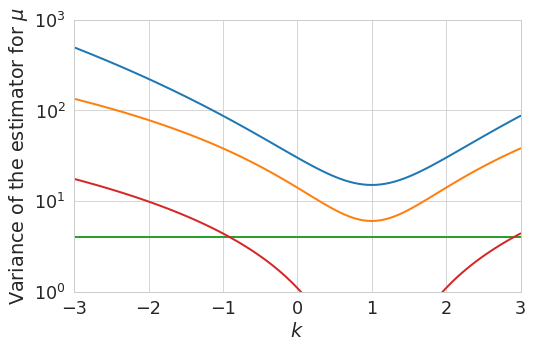

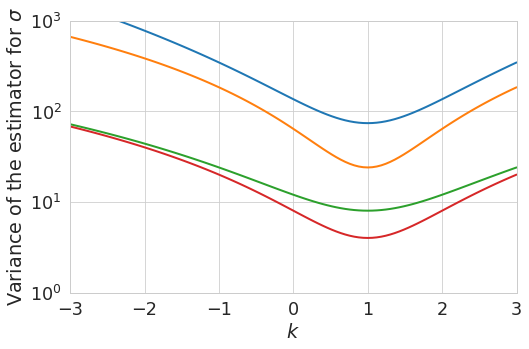

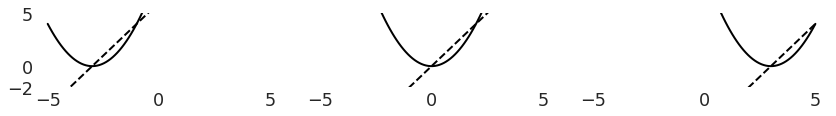

In [0]:
plot(
    k, ret, param_idx=0,
    logx=False, logy=True, ylabel=r'Variance of the estimator for $\mu$',
    ylim=[1., 1e3], filename='variance_mu_{}.pdf'.format(Cost.name))

plot_ax = plot(
    k, ret, param_idx=1,
    logx=False, logy=True, ylabel=r'Variance of the estimator for $\sigma$',
    ylim=[1., 1e3], filename='variance_sigma_{}.pdf'.format(Cost.name))

cartoon_ax = plot_cost_cartoon(
    Cost, k=[np.min(k), 0, np.max(k)], x=np.linspace(-5., 5., 100),
    xticks=[-5, 0, 5], yticks=[-2, 0, 5], ylim=[-2, 5],
    filename='costs_{}.pdf'.format(Cost.name))

### Figure 3 (top): $f(x; k) = \exp(-kx^2)$

In [0]:
Cost = ExponentialCost
k = np.logspace(np.log10(0.1), np.log10(10.), 100)
ret = numerical_integration(Cost, k, mean=1, std=1)
print('Maximum integration error: {}'.format(
    max(np.max(v[..., 1]) for v in ret.values())))

Maximum integration error: 1.4897166192740386e-08


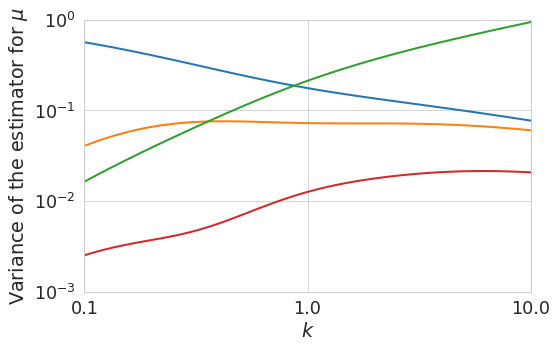

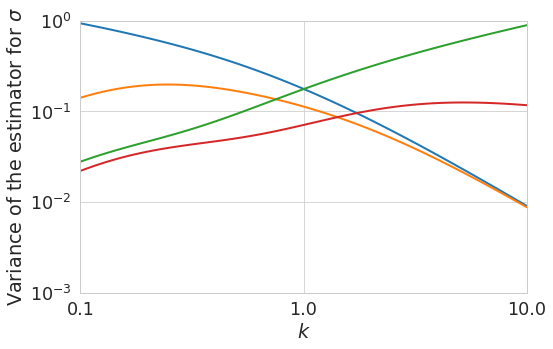

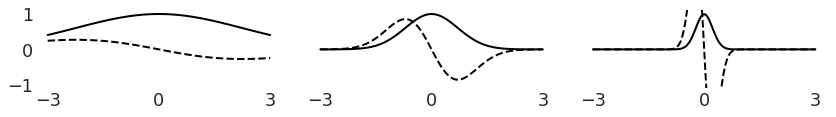

In [0]:
plot(
    k, ret, param_idx=0,
    logx=True, logy=True, ylabel=r'Variance of the estimator for $\mu$',
    ylim=[1e-3, 1], xticks=[0.1, 1, 10],
    filename='variance_mu_{}.pdf'.format(Cost.name))

plot_ax = plot(
    k, ret, param_idx=1,
    logx=True, logy=True, ylabel=r'Variance of the estimator for $\sigma$',
    ylim=[1e-3, 1], xticks=[0.1, 1, 10],
    filename='variance_sigma_{}.pdf'.format(Cost.name))

cartoon_ax = plot_cost_cartoon(
    Cost, k=[np.min(k), 1, np.max(k)], x=np.linspace(-3., 3., 100),
    xticks=[-3, 0, 3], yticks=[-1, 0, 1], ylim=[-1.1, 1.1],
    filename='costs_{}.pdf'.format(Cost.name))

### Figure 3 (bottom): $f(x; k) = \cos kx$

In [0]:
Cost = CosineCost
k = np.logspace(np.log10(0.5), np.log10(5.), 100)
ret = numerical_integration(Cost, k, mean=1, std=1)
print('Maximum integration error: {}'.format(
    max(np.max(v[..., 1]) for v in ret.values())))

Maximum integration error: 1.305700937134977e-07


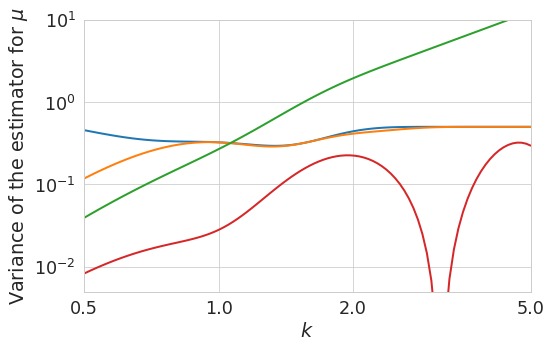

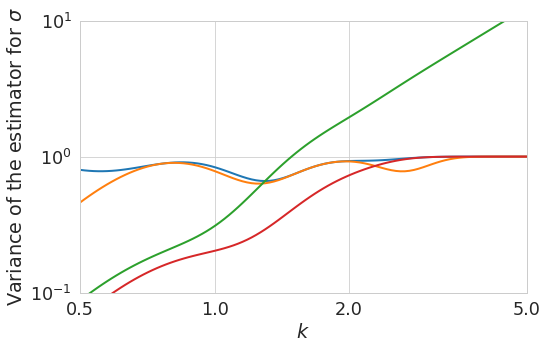

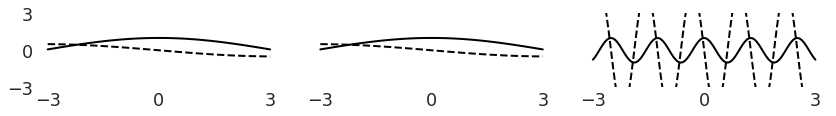

In [0]:
plot(
    k, ret, param_idx=0,
    logx=True, logy=True, ylabel=r'Variance of the estimator for $\mu$',
    ylim=[0.005, 10], xticks=[0.5, 1, 2, 5],
    filename='variance_mu_{}.pdf'.format(Cost.name))

plot_ax = plot(
    k, ret, param_idx=1,
    logx=True, logy=True, ylabel=r'Variance of the estimator for $\sigma$',
    ylim=[0.1, 10], xticks=[0.5, 1, 2, 5],
    filename='variance_sigma_{}.pdf'.format(Cost.name))

cartoon_ax = plot_cost_cartoon(
    Cost,
    k=[np.min(k),
       10 ** ((np.log10(np.min(k)) + np.log10(np.min(k))) / 2),
       np.max(k)],
    x=np.linspace(-3., 3., 100),
    xticks=[-3, 0, 3], yticks=[-3, 0, 3], ylim=[-3, 3],
    filename='costs_{}.pdf'.format(Cost.name))

### Legend for the plots

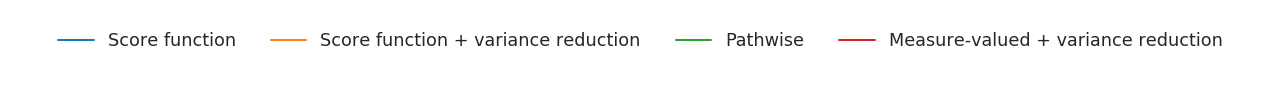

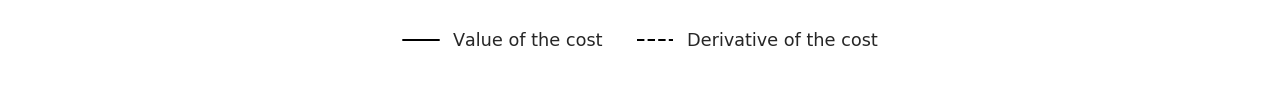

In [0]:
plt.figure(figsize=[22, 1])
plt.axis('off')
plt.grid(False)
plt.legend(*plot_ax.get_legend_handles_labels(), loc='center',
           frameon=False, ncol=5)
if SAVE_PLOTS:
  filename = 'estimators_legend.pdf'
  plt.savefig(filename, dpi=200, transparent=True)

plt.figure(figsize=[22, 1])
plt.axis('off')
plt.grid(False)
plt.legend(*cartoon_ax[0].get_legend_handles_labels(), loc='center',
           frameon=False, ncol=5)
if SAVE_PLOTS:
  filename = 'costs_legend.pdf'
  plt.savefig(filename, dpi=200, transparent=True)